## Using Text Classification for Sentiment Analysis(Binary)

<font color="#00cec9">Import Steam Reviews Dataset from Local Disc

In [ ]:
# Importing libraries
import pandas as pd # data processing, CSV I/O pd.read_csv
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
sns.set(font_scale=1.3)

<font color="#00cec9">Read/Load the Dataset from local disc

In [ ]:
from google.colab import files
upload = files.upload()

Saving steamreviews.zip to steamreviews.zip


In [ ]:
!unzip steamreviews

Archive:  steamreviews.zip
  inflating: train.csv               


In [ ]:
df = pd.read_csv('train.csv')

In [ ]:
df.head()

,review_id,title,year,user_review,user_suggestion
0,1,Spooky's Jump Scare Mansion,2016.0,I'm scared and hearing creepy voices. So I'll...,1
1,2,Spooky's Jump Scare Mansion,2016.0,"Best game, more better than Sam Pepper's YouTu...",1
2,3,Spooky's Jump Scare Mansion,2016.0,"A littly iffy on the controls, but once you kn...",1
3,4,Spooky's Jump Scare Mansion,2015.0,"Great game, fun and colorful and all that.A si...",1
4,5,Spooky's Jump Scare Mansion,2015.0,Not many games have the cute tag right next to...,1


In [ ]:
df = df[['user_review', 'user_suggestion']].dropna()
df.head()

,user_review,user_suggestion
0,I'm scared and hearing creepy voices. So I'll...,1
1,"Best game, more better than Sam Pepper's YouTu...",1
2,"A littly iffy on the controls, but once you kn...",1
3,"Great game, fun and colorful and all that.A si...",1
4,Not many games have the cute tag right next to...,1


In [ ]:
df.count()

user_review        17494
user_suggestion    17494
dtype: int64

In [ ]:
df1 = df.user_suggestion.value_counts()
df1

1    9968
0    7526
Name: user_suggestion, dtype: int64

<font color="#00cec9">Distribution Balance

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


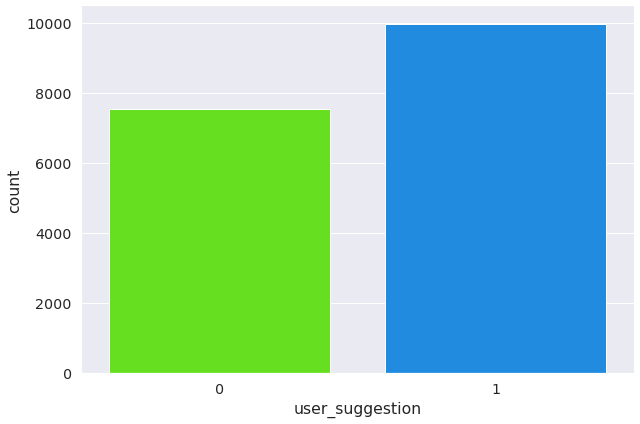

In [ ]:
sns.factorplot(x="user_suggestion", data=df, kind="count", size=6, aspect=1.5, palette="gist_rainbow")
plt.show()

In [ ]:
nlp = spacy.load("en_core_web_sm")
nlp.pipe_names

['tagger', 'parser', 'ner']

In [ ]:
# adding the build-in textcat component to the pipeline
textcat = nlp.create_pipe("textcat", config={"exclusive_classes": True, "architecture": "bow"})
nlp.add_pipe(textcat, last=True)
nlp.pipe_names

['tagger', 'parser', 'ner', 'textcat']

 <font color='00BFEB'>Add Text Classifier Labels<br>
 "Recommended" is for recommended game and "Not Recommended" shows if a review is not recommending the game.

In [ ]:
# Adding Labels to Textcat
textcat.add_label("RECOMMENDED")
textcat.add_label("NOT RECOMMENDED")

1

<font color='00BFEB'> Your default model with textcat is ready, you just need to prepare the data in the required format.

You can write a function load_data() which takes a list of tuples as input. Each tuple contains the text and label value( 0 or 1 ). The below code demonstrates how to convert our reviews data set into this desired format <br/> Generally, apply lambda to rows, as opposed to columns, when performing functionality that needs to access more than one column at a time. </font>


In [ ]:
# converting the dataframe into a list of tuples
df['tuples'] = df.apply(lambda row: (row['user_review'], row['user_suggestion']), axis=1)
train = df['tuples'].tolist()
train[:4]

[("I'm scared and hearing creepy voices.  So I'll pause for a moment and write a review while I wait for my heart beat to return to atleast somewhat calmer times.  This game is adorable and creepy like my happy tree friends but with the graphics sceme of my childhood (but more bubble and 'clean').  Hello 1990's.What charactes there are (that isnot trying to kill me) were likable and a bit odd.  I did do a few noob things though, such as:Oh look a class room full of ghosts from dead children, lets shine my flashlight on them and stand there staring at them..Or, hmm creepy music, I'll turn around and see if I can see what's chasing me.Never before in a game have I been this afraid of finding a locked door.",
  1),
 ("Best game, more better than Sam Pepper's YouTube account. 10/10What you'll need to play:A computerSome extra pants.Pros:Scary as hell.Fun.Adventure.Spooky.Did I forgot to mention that its scary as hell?You'll get more pants/briefs in your wardrobe.Time consuming if you're bo

In [ ]:
import random 
def load_data(limit=0, split=0.8):
  train_data=train
  # shuffle the data
  random.shuffle(train_data)
  texts, labels = zip(*train_data)
  # get the categories for each review
  cats = [{"RECOMMENDED": bool(y), "NOT RECOMMENDED": not bool(y)} for y in labels]

  # Splitting the training and evaluation data
  split = int(len(train_data) * split)
  return (texts[:split], cats[:split]), (texts[split:], cats[split:])

n_texts = 13995

# Calling the load_data() function
(train_texts, train_cats), (dev_texts, dev_cats) = load_data(limit=n_texts)

# Processing the final format of the training data
train_data = list(zip(train_texts, [{'cats': cats} for cats in train_cats]))
train_data[:4]

[("Early Access ReviewThis game is worse than actual garbage. A majority of the weapons do not do anything at all and you're better off running with a knife around the map. The hit boxes are so ♥♥♥♥ed that you walked over people. There is 1 weapon worth buying in this whole game: The ASVAL. If you buy anything else you're ♥♥♥♥ing disabled. I wouldn't recommend this game to anyone unless you're 12 and you're not brave enough to steal your mom's credit card to buy Counter-Strike. The game is just a plain rip-off of it. One of the maps is literally a section of a dust_2 and the devs were so ♥♥♥♥ing lazy they just said ♥♥♥♥ it and closed B halls off and made a TDM map.",
  {'cats': {'NOT RECOMMENDED': True, 'RECOMMENDED': False}}),
 ("The game is absolutely phenomenal and spent hours exploring the world as well as the depths to gain new gear, blocks to build with and rare recipes. Whilst the fact that it is free to play is great, you do get the need to get the 'PRO' version, at least for t

In [ ]:
from spacy.util import minibatch, compounding 
n_iter = 10 # number of training iterations

# disbling other pipeline components
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'textcat']
with nlp.disable_pipes(*other_pipes):
  # only train textcat
  optimizer = nlp.begin_training()

  print("Training the model....")
  
  # Perform training
  for i in range(n_iter):
    print("\nEpoch {}".format(i))
    losses = {}
    batches = minibatch(train_data, size=compounding(4., 32., 1.001))
    for batch in batches:
      texts, annotations = zip(*batch)
      nlp.update(texts, annotations, sgd=optimizer, drop=0.2, losses=losses)

Training the model....

Epoch 0

Epoch 1

Epoch 2

Epoch 3

Epoch 4

Epoch 5

Epoch 6

Epoch 7

Epoch 8

Epoch 9


<font color='00BFEB'>Test the model on unseen data<br>

In [ ]:
# Testing the model
review="the game was boring and we did not have any fun at all - I was very much so dissapointed"
doc=nlp(review)
doc.cats 

{'NOT RECOMMENDED': 0.9753445982933044, 'RECOMMENDED': 0.02465542033314705}

In [ ]:
# Testing the model
new_review="the game was long and it was not too bad but i had much better expectations and it's sad to say - I would not buy this game if I were you"
doc=nlp(new_review)
doc.cats 

{'NOT RECOMMENDED': 0.9986898303031921, 'RECOMMENDED': 0.001310225110501051}

In [ ]:
new_review="best exciting flight simulator EVER!!!!!"
doc=nlp(new_review)
doc.cats 

{'NOT RECOMMENDED': 0.0025494738947600126, 'RECOMMENDED': 0.9974505305290222}

In [ ]:
new_review="wow it was awesome!!!! i showed all my friends!! i did not regret spending money on this game!"
doc=nlp(new_review)
doc.cats 

{'NOT RECOMMENDED': 0.1407880336046219, 'RECOMMENDED': 0.8592119216918945}

In [ ]:
new_review="wow it was awesome!!!! i showed all my friends!! i did not regret spending money on this game!"
doc=nlp(new_review)
doc.cats 

{'NOT RECOMMENDED': 0.1407880336046219, 'RECOMMENDED': 0.8592119216918945}

In [ ]:
new_review="It is not a good game, we thought we would have more fun but it was too long and we never finished till the end. I admit it was more fun than the first part reeased last year"
doc=nlp(new_review)
doc.cats 

{'NOT RECOMMENDED': 0.09685076773166656, 'RECOMMENDED': 0.9031492471694946}

<font color='00BFEB'> Evaluation Model</font>  <br/>
 <font color='#fd79a8'> Now that the training data is formatted above, there is one more step before training the textcat on the Steam_Reviews data. The model must first be evaluated. We will use <font color='#ffdd59'>function evaluate()  </font>  <br>Above: the training data is now in the desired format and stored it in <font color='#ffdd59'>train_data variable </font>. 
This is an optional step for the tutorial but highly recommended when doing real world projects. If you recall, the load_data() function split around 20% of the original data for evaluation. We’ll be using this to test how good the training was.

In [ ]:
def evaluate(tokenizer, textcat, texts, cats):
  docs = (tokenizer(text) for text in texts)
  tp = 0.0 # true positive
  fp = 1e-8 # false positive
  fn = 1e-8 # false negative
  tn = 0.0 # true negative
  for i, doc in enumerate(textcat.pipe(docs)):
    gold = cats[i]
    for label, score in doc.cats.items():
      if label not in gold:
        continue
      if label == "NEGATIVE":
        continue
      if score >= 0.5 and gold[label] >= 0.5:
        tp += 1.0
      elif score >= 0.5 and gold[label] < 0.5:
        fp += 1.0
      elif score < 0.5 and gold[label] < 0.5:
        tn += 1
      elif score < 0.5 and gold[label] < 0.5:
        fn += 1
  precision = tp / (tp + fp)
  recall = tp / (tp + fn)
  if (precision + recall) == 0:
    f_score = 0.0
  else:
    f_score = 2 * (precision * recall) / (precision + recall)
  return {"textcat_p": precision, "textcat_r": recall, "textcat_f": f_score}